In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [15]:
NUM_WORDS = 10000
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

In [20]:
def create_ngram_set(input_list, ngram_value=2):
    '''
    Extract a set of n-grams from a list of integers.
    # >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    # >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    '''
#     print([input_list[i:] for i in range(ngram_value)])
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))

create_ngram_set([2, 3, 4, 5 ,6], ngram_value=3)

{(2, 3, 4), (3, 4, 5), (4, 5, 6)}

In [25]:
def add_ngram(sequences, token_indice, ngram_range=2):
    '''
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    # >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    # >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    # >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    # >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    # >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    # >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    '''
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
#             print('ngram_value', ngram_value)
            for i in range(len(new_list) - ngram_value + 1):
#                 print('i', i)
                ngram = tuple(new_list[i:i + ngram_value])
#                 print('ngram', ngram)
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
#                     print('new_list', new_list)
        new_sequences.append(new_list)

    return new_sequences

sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
add_ngram(sequences, token_indice, ngram_range=3)

[[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]

In [26]:
def create_ngram_vocabulary(sequences, max_features=10000, ngram_range=2):
    if ngram_range > 1:
        print('Adding {}-gram features'.format(ngram_range))
        # Create set of unique n-gram from the training set.
        ngram_set = set()
        for sequence in sequences:
            for i in range(2, ngram_range + 1):
                set_of_ngram = create_ngram_set(sequence, ngram_value=i)
                ngram_set.update(set_of_ngram)

        # Dictionary mapping n-gram token to a unique integer.
        # Integer values are greater than max_features in order
        # to avoid collision with existing features.
        start_index = max_features + 1
        token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
        indice_token = {token_indice[k]: k for k in token_indice}

        # max_features is the highest integer that could be found in the dataset.
        max_features = np.max(list(indice_token.keys())) + 1
    else:
        token_indice = {}
        indice_token = {}
        
    return max_features, token_indice, indice_token

In [27]:
max_features, token_indice, indice_token = create_ngram_vocabulary(train_data)

Adding 2-gram features


In [29]:
print('train sequences', len(train_data))
print('test sequences', len(test_data))
print('Average train sequence length: {}'.format(np.mean(list(map(len, train_data)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, test_data)), dtype=int)))

# Augmenting x_train and x_test with n-grams features
train_data = add_ngram(train_data, token_indice, ngram_range=2)
test_data = add_ngram(test_data, token_indice, ngram_range=3)
print('Average train sequence length: {}'.format(np.mean(list(map(len, train_data)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, test_data)), dtype=int)))

train sequences 25000
test sequences 25000
Average train sequence length: 238
Average test sequence length: 230
Average train sequence length: 476
Average test sequence length: 436


In [30]:
class FastText(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=1,
                 last_activation='sigmoid'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = keras.Input((self.maxlen,))
        embedding = keras.layers.Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        x = keras.layers.GlobalAveragePooling1D()(embedding)
        output = keras.layers.Dense(self.class_num, activation=self.last_activation)(x)
        model = keras.Model(inputs=input, outputs=output)
        return model

In [32]:
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 10

model = FastText(maxlen, max_features, embedding_dims).get_model()
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [36]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

train_data = sequence.pad_sequences(train_data, maxlen=maxlen)
test_data = sequence.pad_sequences(test_data, maxlen=maxlen)

early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max')

history = model.fit(train_data, train_labels,
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[early_stopping],
                  validation_data=(test_data, test_labels))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 587s 23ms/sample - loss: 0.2617 - accuracy: 0.9306 - val_loss: 0.2933 - val_accuracy: 0.8925
Epoch 2/10
25000/25000 [==============================] - 594s 24ms/sample - loss: 0.1404 - accuracy: 0.9692 - val_loss: 0.2584 - val_accuracy: 0.8999
Epoch 3/10
25000/25000 [==============================] - 630s 25ms/sample - loss: 0.0796 - accuracy: 0.9865 - val_loss: 0.2445 - val_accuracy: 0.9026
Epoch 4/10
25000/25000 [==============================] - 578s 23ms/sample - loss: 0.0465 - accuracy: 0.9941 - val_loss: 0.2370 - val_accuracy: 0.9050
Epoch 5/10
25000/25000 [==============================] - 610s 24ms/sample - loss: 0.0277 - accuracy: 0.9976 - val_loss: 0.2380 - val_accuracy: 0.9044
Epoch 6/10
25000/25000 [==============================] - 637s 25ms/sample - loss: 0.0168 - accuracy: 0.9986 - val_loss: 0.2378 - val_accuracy: 0.9050
Epoch 7/10
25000/25000 [====================

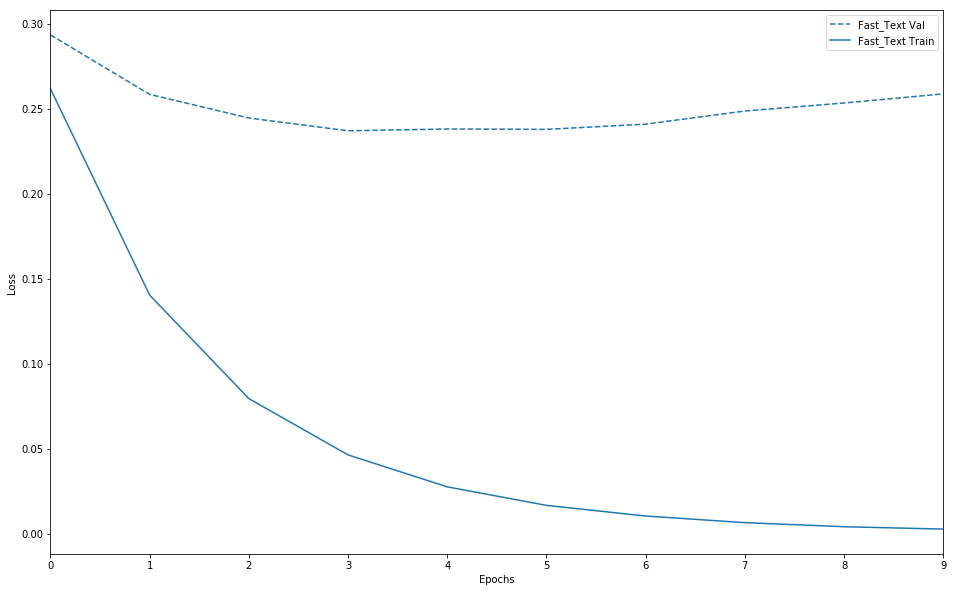

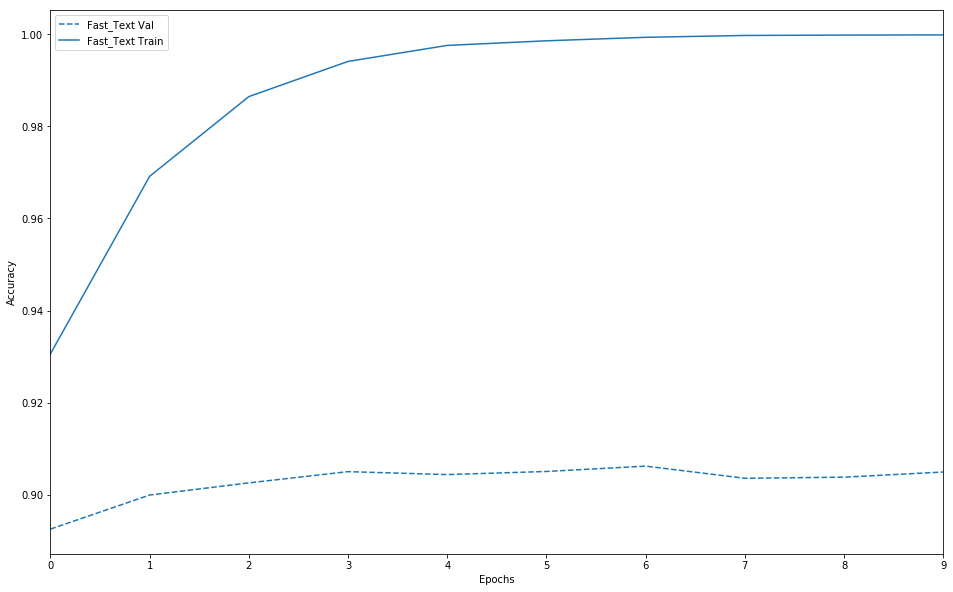

In [41]:
import matplotlib.pyplot as plt

def plot_history(histories, key='loss'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])


plot_history([('fast_text', history)], key='loss')
plot_history([('fast_text', history)], key='accuracy')

In [42]:
result = model.predict(test_data)

In [44]:
result[:10]

array([[0.07749298],
       [0.99999976],
       [0.73829484],
       [0.09347183],
       [0.9975821 ],
       [0.99642134],
       [0.9955351 ],
       [0.00161663],
       [0.99347454],
       [0.99948883]], dtype=float32)